<div align="center">
<font size = 6>
<strong>Simulating Cyclotrons: Python Final Project</strong>
</font>
<div align="center">
<font size = 4>
Jonah Allen Nan
<div align="center">
Physics 260 Winter 2020
</div>

**Abstract**

A cyclotron is a type of particle accelerator. This project investigates particle motion in a cyclotron by simulating the cyclotron in python. The central question is: what happens when we vary the frequency at which a cyclotron is driven? We'll also investigate how Euler's method compares to the Runge-Kutta integration scheme. We begin with a description of the motivation for the project. We then describe the theory behind cyclotrons and how they work. Next, we explain how we will simulate the cyclotron in python. After that, we run a basic simulation to ensure our model is correct. We then test how Euler's method compares to Runge-Kutta, and we investigate the effects of slightly modifying the driving frequency. We find that Euler's method is quite similar to Runge-Kutta when simulating the cyclotron, and we find that modifying the driving frequency even slightly has a drastic impact on the particle's motion. We conclude by discussing limitations of our model and potential improvements.

**Motivation**

While cyclotrons are not exactly state-of-the-art, they provide an interesting example of the power of combining electric and magnetic fields. The principle by which the cyclotron operates is relatively simple and readily accessible to anyone who has taken this course, yet a cyclotron is able to achieve particle energies of millions of electron volts (1). It’s really neat to see how the simple laws of electricity and magnetism can be cleverly applied to create spectacular results. This project will also allow us to study the limits of the numerical integration techniques we’ve discussed so far in class. 

**Background**

A cyclotron consists of two semi-circular pieces of metal called dees (because they look like the letter D) suspended between the poles of a magnet. The magnet is large enough that the magnetic field in the cyclotron is approximately constant. A sinusoidally oscillating voltage is applied to the dees, creating an oscillating electric field in the gap between them. (3)

A particle is emitted from the center of the cyclotron. The particle then begins to spiral outwards. The electric field frequency is such that each time the particle enters the gap between the dees, the electric field is aligned with the particle's direction of motion and causes it to speed up. When the particle is within the dees, the constant B field causes it to move in a semicircular arc. It then speeds up again when it exits the dee and encounters the electric field. The particle gets faster and faster as it spirals away from the center. When the particle reaches the outer edge of the cyclotron, it is emitted. 

Here's a diagram of a cyclotron (1):

In [1]:
# Image from (1)
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn.britannica.com/68/3368-050-1EEDBBAC/particles-cyclotron-Plan-view-middle-dees-magnetic.jpg")

The frequency of the electric field must be such that the field is always aligned with the particle's velocity when the particle is in the region of the field. Using what we know about particles moving in constant magnetic fields, we find that the correct frequency to use is $$f = \frac{qB}{2 \pi m}$$ where q is the particle's charge, B is the magnitude of the magnetic field, and m is the particle's mass (2).

**Setup**

As usual, we begin with imports. These are all imports that we've seen in class, there's nothing new here.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Next, we will define functions which give the electric and magnetic fields at a given point in space and a given time. Note that unlike in the computer homeworks from class, our functions here will be time-dependent.

We begin by defining our coordinate system. We will let our cyclotron lie in the x-y plane, with the origin at its center. The dees will lie on different sides of the y-axis. Thus, the electric field will be parallel to the x-axis. 
The magnetic field will be in the positive z direction, perpendicular to the plane of the cyclotron.

Our functions will be called electric_field and magnetic_field. They will take the position (as a vector) and the time as inputs, and return a vector representing the correct field.

The magnetic field is spatially uniform and constant over time, so the magnetic_field function just returns a constant: $B = B_0 \hat{\textbf{k}}$

The electric field is zero except in the region between the dees. We let this region be given by $|x| < x_0$. This region has length $d = 2x_0$. In this region, we apply a sinusoidally varying voltage with amplitude $V_0$ and frequency $f$: $V = V_0 sin(\omega t)$. We then have that the corresponding electric field is $E = \frac{V_0}{d} sin(\omega t)\hat{\textbf{i}} = \frac{V_0}{2x_0} sin(\omega t)\hat{\textbf{i}}$. Recall that the Cyclotron frequency is given by $f = \frac{qB}{2 \pi m}$.

These functions depend on constants $B_0$, $V_0$, $x_0$, $m$, and $q$, which come from the physical setup of a given cyclotron and which we can easily modify in the code. We will choose values of 1 when possible to simplify calculations. This means this simulation's specific numbers aren't accurate to real cyclotrons, but the general behavior should be the same. 

In [3]:
# We define the constants which come from the physical setup of our cyclotron
# To make computation simpler, we use values of 1 where possible, 
# even if these aren't accuate to a real cyclotron.
B_0 = 1 #  B field magnitude
V_0 = 1e6 # Voltage between dees
m = 1 # Particle mass
q = 1 # Particle charge
x_0 = 1 # Position of dees

f = 1 / (2 * np.pi) # Voltage frequency
omega = 2 * np.pi * f

def magnetic_field(position, t):
    return np.array([0, 0, B_0])

def electric_field(position, t):
    x = position[0]
    if abs(x) < x_0:
        E_x = (V_0 / (2 * x_0)) * np.sin(omega * t)
        return np.array([E_x, 0, 0])
    else:
        return np.array([0, 0, 0])

The next few steps are all very similar to computer homework 7. We will borrow some code from that assignment. We will be less in-depth with explanations of how these functions work, as they should all be familiar.

We define functions to calculate the force on a particle by a given E field or B field:

In [4]:
#From computer HW 7
def calc_force_on_charge_by_efield(electric_field, q = 1) :
    ''' We have one argument, and a key-word argument. The electric_field should look like a vector, 
    i.e. a numpy array with three elements. q has a DEFAULT value of 1 Coulomb'''
    force = q*electric_field
    return force

def calc_force_on_charge_by_bfield(magnetic_field, charge_velocity, q = 1) :
    ''' Fill out description of appropriate arguments and/or keyword arguments.  magnetic field and velocity also
    need to be vectors, i.e. numpy arrays with three elements.  You will need to use np.cross
    from above. '''
    force = q*np.cross(charge_velocity, magnetic_field)
    return force

We define a function using these to compute the acceleration of a particle in a region with E and B fields:

In [5]:
#From computer HW 7
def calc_acceleration_of_charge_in_ebfields(electric_field, magnetic_field, charge_velocity, q, m) :
    ''' Calculate the acceleration of a charge in both electric and magnetic fields.  electric_field, magnetic_field,
    charge_velocity should all be vector-looking, i.e. numpy arrays with three elements'''
    acceleration = (calc_force_on_charge_by_efield(electric_field, q) + \
                    calc_force_on_charge_by_bfield(magnetic_field, charge_velocity, q))/m
    return acceleration

We define a function to update a value given the rate of change:


In [6]:
#From computer HW 7
def get_updated_value(current_value, rate_of_change, dt) :
    updated_value = current_value + rate_of_change*dt
    return updated_value

Now, we define a function to apply Euler's method to update particle trajectories over a small timestep. This function is very similar to the one from computer homework 7. The key difference is that our magnetic_field and electric_field functions now take time as an argument, because the fields are not constant over time.

In [7]:
#This function is taken from the handout code for computer HW 7, with minor modifications.
def get_rates_of_change_euler(particle_position, particle_velocity, electric_field_function,
                                        magnetic_field_function, q, m, dt, t) :
    '''When using Euler's method, the rates of change are simply the particle_velocity, and the acceleration
    due to the electric and magnetic field at that particle_position.  While this does not depend on dt, 
    we will keep it as an argument for parallels with the Runge-Kutta method'''
    
    electric_field_at_position = electric_field_function(particle_position, t)
    magnetic_field_at_position = magnetic_field_function(particle_position, t)
    
    particle_acceleration = calc_acceleration_of_charge_in_ebfields(electric_field_at_position, 
                                                                    magnetic_field_at_position, 
                                                                        particle_velocity, q, m)
    return particle_velocity, particle_acceleration

We also define a Runge-Kutta update function, modified to account for time-varying fields:

In [8]:
#This function is taken from the handout code for computer HW 7, with minor modifications.
def get_rates_of_change_runge_kutta(particle_position, particle_velocity, electric_field_function,
                                        magnetic_field_function, q, m, dt, t) :
    ''' This uses the Runge-Kutta method to calculate the updated value.  This method relies on mid-points.
    Note, this method can replace get_rates_of_change_euler in the argument, get_rates_of_change_function, that
    is input to calc_trajectory_in_fields'''

    current_velocity, current_acceleration = get_rates_of_change_euler(particle_position, particle_velocity, electric_field_function,
                                        magnetic_field_function, q, m, dt, t)
    
    mid_particle_velocity = current_velocity + current_acceleration * dt/2
    mid_particle_position = particle_position + mid_particle_velocity * dt/2
    
    # Calculate the acceleration due to the electric and magnetic fields at the mid_particle_position
    runge_kutta_velocity, runge_kutta_acceleration = get_rates_of_change_euler(mid_particle_position, mid_particle_velocity,
                                                                        electric_field_function,
                                                                        magnetic_field_function, q, m, dt, t)
    return runge_kutta_velocity, runge_kutta_acceleration

We define a function to give a placeholder array:


In [9]:
#From computer HW 7
def create_place_holder_array(timesteps) :
    ''' Returns a placeholder array '''
    return np.zeros((timesteps.size,3))

Finally, we define our most important function: calc_trajectory_in_fields. We use all the functions we've borrowed from HW 7 to define a function which will compute a particle's trajectory for given initial conditions. We modify the function to account for the fact that the fields change over time.

In [10]:
#Modified from HW 7 
def calc_trajectory_in_fields(electric_field_function, magnetic_field_function, get_rates_of_change_function, 
                              timesteps, particle_position, particle_velocity, q = 1, m=1) :
    '''This function takes in functions that output the electric (and magnetic) fields functions with an argument of particle
    position.  This also requires as an argument the timesteps you wish to iterate over, and the 
    initial conditions, of the particle_position and particle_velocity it starts out with.  The charge and mass
    are optional (key word arguments).'''
    
    # Create place holder arrays
    position_evolution = create_place_holder_array(timesteps)
    velocity_evolution = create_place_holder_array(timesteps)
    
    dt = timesteps[1]  # timesteps looks like np.array([0, dt, 2*dt, 3*dt, ...., (total_timesteps-1)*dt])
    for inum, timestep in enumerate(timesteps) :
        # Populate
        position_evolution[inum,:] = particle_position
        velocity_evolution[inum,:] = particle_velocity
        
        # Calculate velocity and acceleration due to e- and b-fields to update particle_position and particle_velocity
        # Here, we modify the code to include the current time as an argument to the calculation
        position_rate_of_change, velocity_rate_of_change = \
            get_rates_of_change_function(particle_position, particle_velocity, electric_field_function,
                                        magnetic_field_function, q, m, dt, timestep)
        
        # Update
        particle_position = get_updated_value(particle_position, position_rate_of_change, dt)
        particle_velocity = get_updated_value(particle_velocity, velocity_rate_of_change, dt)
        
    return position_evolution, velocity_evolution

We now have everything we need to begin calculating the trajectories of particles in a cyclotron.

**Results and Conclusions**

Now, let's try actually simulating some trajectories!
We'll begin with a basic example. Our particle will start from rest at the origin. We'll use Euler's method to compute the trajectory. We expect it will spiral out of the cyclotron. Let's see what happens!

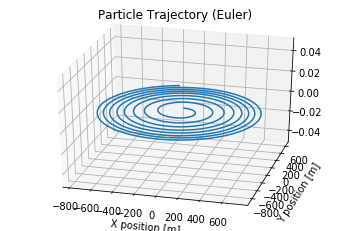

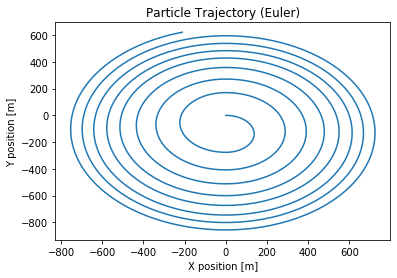

In [11]:
#Initial conditions
initial_position = np.array([0,0,0])
initial_velocity = np.array([0,0,0])
timesteps = np.arange(0,50,0.001)

#Compute trajectory
trajectory_evolution, velocity_evolution = calc_trajectory_in_fields(electric_field, magnetic_field,
                         get_rates_of_change_euler, timesteps, initial_position, initial_velocity)

#Graph the results
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(30,-75)
ax.plot(trajectory_evolution[:,0],trajectory_evolution[:,1],trajectory_evolution[:,2])
plt.title("Particle Trajectory (Euler)")
plt.xlabel("X position [m]")
plt.ylabel("Y position [m]")
plt.show()

plt.plot(trajectory_evolution[:,0], trajectory_evolution[:,1])
plt.title("Particle Trajectory (Euler)")
plt.xlabel("X position [m]")
plt.ylabel("Y position [m]")
plt.show()

Hooray! It spiraled outwards, just as we expected. Note that the motion is all in the x-y plane, so we needn't show 3d plots. This makes sense: The particle should only move within the plane of the cyclotron. From now on, we'll just display 2d plots of the x-y trajectory.

However, these plots only show us the particle's trajectory, not its velocity. In an accelerator, velocity is pretty important. The main point of these devices is to accelerate particles to high velocities. So, let's check out how the particle's velocity changes over time. We're mainly interested in the magnitude of the particle's velocity, so what's what we'll graph.

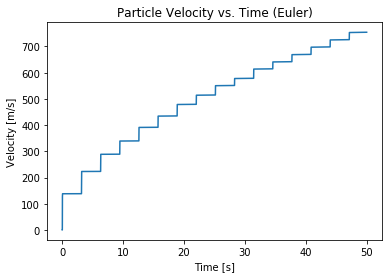

In [12]:
# Plot velocity over time

#Compute magnitude of velocity
velocity_mag = np.zeros(len(velocity_evolution))
for i in range(len(velocity_evolution)):
    velocity_mag[i] = np.linalg.norm(velocity_evolution[i])

# Plot it
plt.plot(timesteps, velocity_mag)
plt.title("Particle Velocity vs. Time (Euler)")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.show()

Final_vel_Euler = velocity_mag[-1]

At first, this graph might look a bit odd. But, when we think about what's actually going on, it makes perfect sense. We know that the magnetic force will never change the magnitude of the particle's velocity. So, while the particle is in the dees and there is no electric force, the magnitude of the particle's velocity remains constant. On the other hand, when the particle is in the electric field region between the dees, the E field accelerates the particle and increases its velocity. So, the particle's velocity increases over time in discrete steps.

What about the size of these steps, though? Why do they appear irregular? This makes more sense when we plot kinetic energy over time:

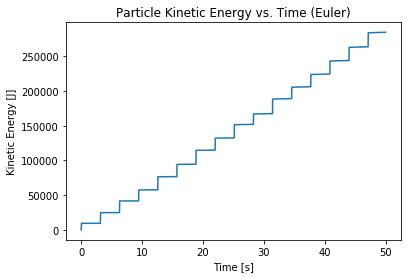

In [13]:
# Calculate particle kinetic energy
KE = np.zeros(len(velocity_mag))
for i in range(len(velocity_mag)):
    KE[i] = .5 * m * (velocity_mag[i])**2
    
# Plot KE over time
plt.plot(timesteps, KE)
plt.title("Particle Kinetic Energy vs. Time (Euler)")
plt.xlabel("Time [s]")
plt.ylabel("Kinetic Energy [J]")
plt.show()

We see that the kinetic energy steps up by (nearly) the same amount each time the particle passes through the electric field region. This is because the change in energy as the particle moves through the field is given by the potential between the dees times the particle charge. The frequency is such that the potential between the dees will be $V_0$ every time the particle enters the electric field region, so the particle's energy will step up by a uniform amount each time it passes between the dees.

Note that this is an approximation: in reality, the voltage is changing as the particle passes through the electric field region, so we can't just say $\Delta KE = qV$. But, since the width of the electric field region is small compared to the particle velocity, this change is negligible. So, the particle's energy actually increases by an approximately constant amount whenever it passes through the electric field region.

You might be thinking: "Wait! How does the particle keep gaining energy indefinitely? Where is this energy coming from? I don't see any external agent doing work!" However, there IS an external agent doing work. Recall that the voltage between the dees is constantly oscillating. Something needs to do work to change this voltage. In fact, we need to do quite a lot of work to get the particle to high velocities. We need a large voltage (thousands of volts (2)) between the dees, and we need to change this voltage quite quickly. (The formula for $f$ involves a factor of the particle's charge to mass ratio, which is on the order of $10^8$ for a proton and on the order of $10^{11}$ for an electron). Of course, this makes sense: to accelerate a particle to high energies, we need to put that much energy into the system.

So, our basic cyclotron model manages to capture the essential components of real cyclotron motion: the particle spirals out while its energy increases.

Next, we'll compare the Euler's method trajectory to the Runge-Kutta trajectory. In class, we learned that runge-kutta is more accurate than Euler's method. We'll repeat the tests we just ran, using Runge-Kutta instead of Euler's method:

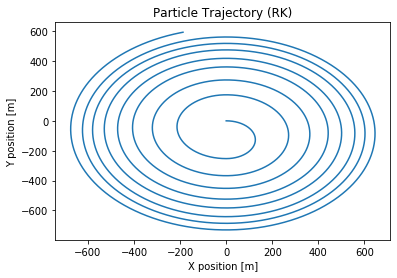

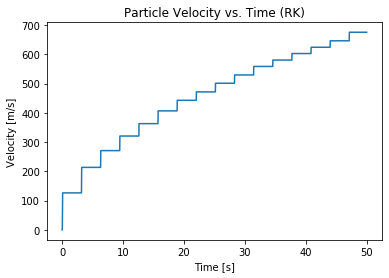

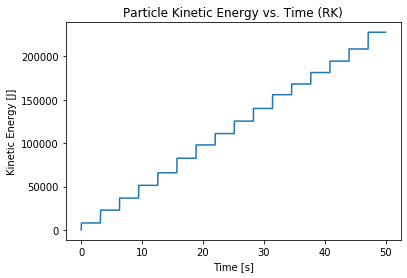

Euler final velocity: 754.3203093317748
Runge-Kutta final velocity: 675.2354508806442


In [14]:
#Initial conditions
initial_position = np.array([0,0,0])
initial_velocity = np.array([0,0,0])
timesteps = np.arange(0,50,0.001)

#Compute trajectory
trajectory_evolution, velocity_evolution = calc_trajectory_in_fields(electric_field, magnetic_field,
                         get_rates_of_change_runge_kutta, timesteps, initial_position, initial_velocity)

#Graph the results
plt.plot(trajectory_evolution[:,0], trajectory_evolution[:,1])
plt.title("Particle Trajectory (RK)")
plt.xlabel("X position [m]")
plt.ylabel("Y position [m]")
plt.show()

# Plot velocity over time

#Compute magnitude of velocity
velocity_mag = np.zeros(len(velocity_evolution))
for i in range(len(velocity_evolution)):
    velocity_mag[i] = np.linalg.norm(velocity_evolution[i])

# Plot it
plt.plot(timesteps, velocity_mag)
plt.title("Particle Velocity vs. Time (RK)")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.show()

Final_vel_RK = velocity_mag[-1]

# Calculate particle kinetic energy
KE = np.zeros(len(velocity_mag))
for i in range(len(velocity_mag)):
    KE[i] = .5 * m * (velocity_mag[i])**2
    
# Plot KE over time
plt.plot(timesteps, KE)
plt.title("Particle Kinetic Energy vs. Time (RK)")
plt.xlabel("Time [s]")
plt.ylabel("Kinetic Energy [J]")
plt.show()

print("Euler final velocity:", Final_vel_Euler)
print("Runge-Kutta final velocity:", Final_vel_RK)

The Runge-Kutta results are surprisingly similar to the results from Euler's method. They're not quite the same: Euler's method gives a final velocity of about 754 m/s, while Runge-Kutta gives 675 m/s. However, the differences are slight enough that it's difficult to tell the two sets of graphs apart at a glance. I expected the Runge-Kutta method to be significantly superior to Euler's method, but the difference was smaller than I expected. 

For our final experiment, we'll see what happens if we change the cyclotron frequency slightly. We'll plot the trajectory for the correct frequency $f$, then we'll plot it for $1.01f, 1.03f, 1.05f,$ and $1.1f$.

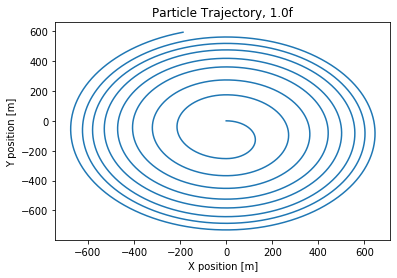

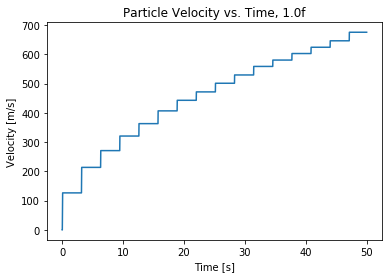

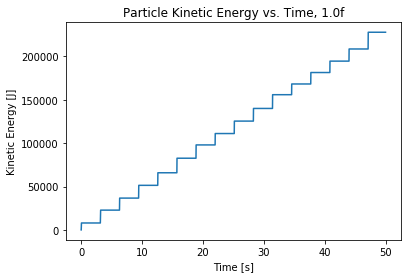

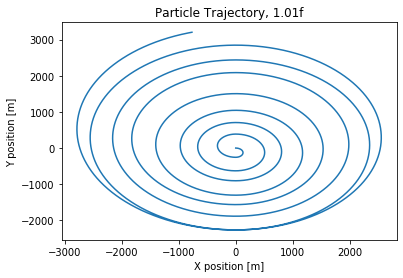

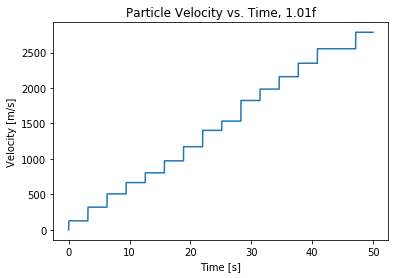

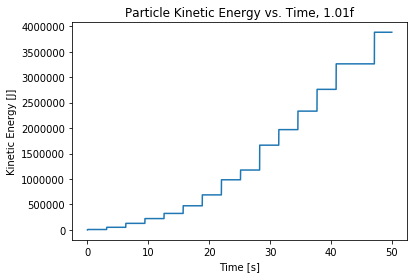

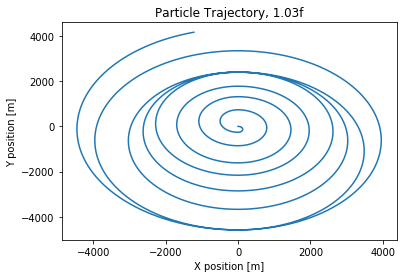

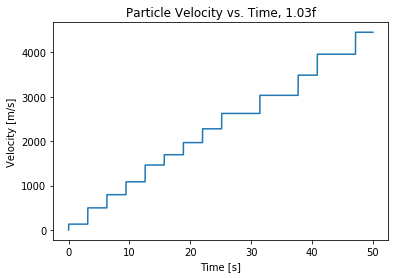

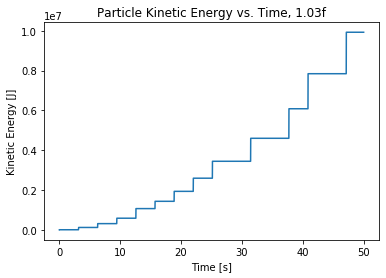

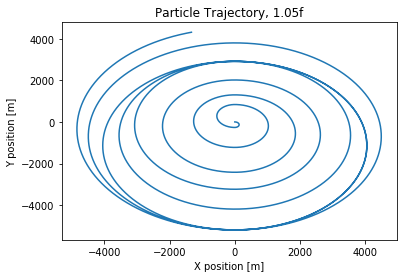

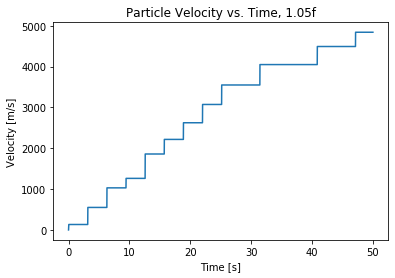

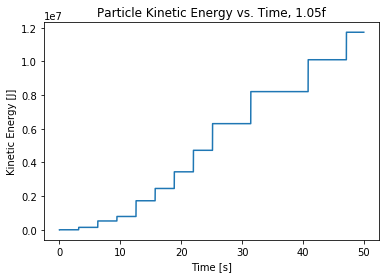

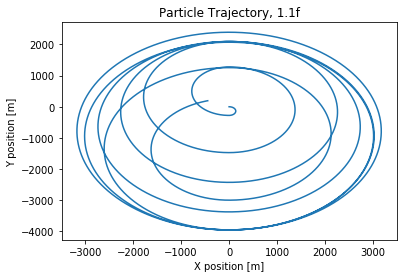

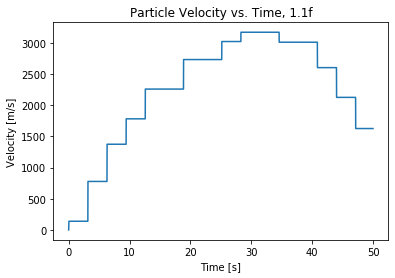

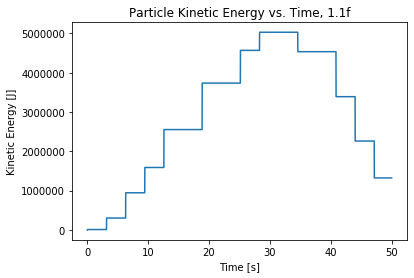

In [15]:
# store the correct value of f
true_f = q*B_0 / (2 * np.pi * m)

#Which multiples of f to plot?
multiplier_list = np.array([1, 1.01, 1.03, 1.05, 1.1])

#Initial conditions
initial_position = np.array([0,0,0])
initial_velocity = np.array([0,0,0])
timesteps = np.arange(0,50,0.001)

# Loop over different frequencies and plot motion
for i in range(len(multiplier_list)):
    f = true_f * multiplier_list[i]
    omega = 2 * np.pi * f
    #Compute trajectory
    trajectory_evolution, velocity_evolution = calc_trajectory_in_fields(electric_field, magnetic_field,
                             get_rates_of_change_runge_kutta, timesteps, initial_position, initial_velocity)

    #Graph the results
    plt.plot(trajectory_evolution[:,0], trajectory_evolution[:,1])
    plt.title("Particle Trajectory, " + str(multiplier_list[i]) + "f")
    plt.xlabel("X position [m]")
    plt.ylabel("Y position [m]")
    plt.show()
    
    # Plot velocity over time

    #Compute magnitude of velocity
    velocity_mag = np.zeros(len(velocity_evolution))
    for j in range(len(velocity_evolution)):
        velocity_mag[j] = np.linalg.norm(velocity_evolution[j])

    # Plot it
    plt.plot(timesteps, velocity_mag)
    plt.title("Particle Velocity vs. Time, " + str(multiplier_list[i]) + "f")
    plt.xlabel("Time [s]")
    plt.ylabel("Velocity [m/s]")
    plt.show()

    Final_vel_RK = velocity_mag[-1]

    # Calculate particle kinetic energy
    KE = np.zeros(len(velocity_mag))
    for k in range(len(velocity_mag)):
        KE[k] = .5 * m * (velocity_mag[k])**2
    
    # Plot KE over time
    plt.plot(timesteps, KE)
    plt.title("Particle Kinetic Energy vs. Time, " + str(multiplier_list[i]) + "f")
    plt.xlabel("Time [s]")
    plt.ylabel("Kinetic Energy [J]")
    plt.show()
    

We see that if we modify the frequency even slightly, the resulting trajectory varies wildly. In addition, when the frequency is wrong, we lose the nice pattern of uniform steps up in kinetic energy. Instead, the particle's energy changes seemingly at random. For frequencies which deviate enough from the correct one, the particle can even start to lose energy. This demonstrates that it's crucial for the electric field to oscillate at the exact frequency which allows it to always be aligned with the particle's velocity. 

**Limitations and Future Work**

We made a number of simplifying assumptions in our model of the cyclotron. For one thing, cyclotrons have exits and are finite. Yet, our model treats the cyclotron as infinite. Modeling the electric and magnetic fields as spatially uniform is another simplifying assumption, but a necessary one. Trying to account for edge effects would make the system needlessly complex with little added accuracy. Finally, the model assumes that the forces from the given electric and magnetic fields are the only forces which act on the particle. In practice, this is unlikely. This is why cyclotrons are supposed to be vacuums (2): to prevent other forces from interfering with the particle.

In real cyclotrons, relativistic effects can come into play when particles start moving fast enough (1). This simulation does not account for relativity at all. We don't even use realistic values for particle mass or charge, so accounting for relativity would be tricky. We'd need to use realistic values for all our constants, and modify the code to account for relativity. This would make things a lot more computationally intensive, but more realistic.

Finally, we could have used a better integration scheme than Runge-Kutta or Euler. The Boris integration scheme is the standard for the motion of charged particles (4), so using it would likely make our simulation more accurate.

**Works Cited**

1. The Editors of Encyclopaedia Britannica. “Cyclotron.” Encyclopædia Britannica, Encyclopædia Britannica, Inc., 8 Feb. 2018, www.britannica.com/technology/cyclotron.
2. “Cyclotron.” Wikipedia, Wikimedia Foundation, 11 Mar. 2020, en.wikipedia.org/wiki/Cyclotron.
3. "Cyclotron.", Hyperphysics, Georgia State University, hyperphysics.phy-astr.gsu.edu/hbase/magnetic/cyclot.html.
4. Qin, Hong & Zhang, Shuangxi & Xiao, Jianyuan & Liu, Jian & Sun, Yajuan & Tang, William. (2013). Why is Boris algorithm so good?. Physics of Plasmas. 20. 10.1063/1.4818428. 